In [134]:
import warnings
import pandas as pd
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import correctionlib
import awkward as ak
import fastjet
import coffea
from coffea.nanoevents.methods import vector
from coffea import nanoevents
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.analysis_tools import Weights, PackedSelection
from hist import Hist
ak.behavior.update(vector.behavior)

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Missing cross-reference index ")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [135]:
print(coffea.__version__, coffea.__file__)
print(ak.__version__, ak.__file__)
print(uproot.__version__, uproot.__file__)
print(np.__version__, np.__file__)

0.7.22 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/__init__.py
1.10.5 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/awkward/__init__.py
4.3.7 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/uproot/__init__.py
1.23.5 /Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/numpy/__init__.py


In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/TTbar/file1.root")
num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events();

number of events per file is 46000


In [176]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

met = events.MET

# lepton
electrons = events["Electron"][events["Electron"].pt > 40]
muons = events["Muon"][events["Muon"].pt > 30]
leptons = ak.concatenate([electrons, muons], axis=1)
leptons = leptons[ak.argsort(leptons.pt, ascending=False)]
candidatelep = ak.firsts(leptons)
candidatelep_p4 = build_p4(candidatelep)

# fatjet
fatjets = events["FatJet"]
good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight

good_fatjets = fatjets[good_fatjets]  # select good fatjets
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

NumFatjets = ak.num(good_fatjets)
FirstFatjet = ak.firsts(good_fatjets[:, 0:1])
SecondFatjet = ak.firsts(good_fatjets[:, 1:2])

# candidatefj
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

In [180]:
import sys
sys.path.append('../')

from boostedhiggs.corrections import get_btag_weights

jets = events.Jet

jet_selector = (
    (jets.pt > 30)
    & (abs(jets.eta) < 5.0)
    & jets.isTight
    & ((jets.pt >= 50) | ((jets.pt < 50) & (jets.puId & 2) == 2))
)

bjet_selector = (jet_selector) & (jets.delta_r(candidatefj) > 0.8) & (abs(jets.eta) < 2.5)
btga_dict = get_btag_weights("2017", jets, bjet_selector, wp="T", algo="deepJet", systematics=True)
btga_dict.keys()

dict_keys(['weight_btag', 'weight_btagSFlight2017Up', 'weight_btagSFlight2017Down', 'weight_btagSFbc2017Up', 'weight_btagSFbc2017Down', 'weight_btagSFlightCorrelatedUp', 'weight_btagSFlightCorrelatedDown', 'weight_btagSFbcCorrelatedUp', 'weight_btagSFbcCorrelatedDown', 'bcEff', 'lightEff'])

In [181]:
btga_dict["bcEff"]

<Array [0.612, 0.556, 0.683, ... 0.681, 0.683] type='5363 * float64'>

In [182]:
btga_dict["lightEff"]

<Array [0.000932, 0.000675, ... 0.000675] type='7108 * float64'>

Text(1, 0, 'Efficiency')

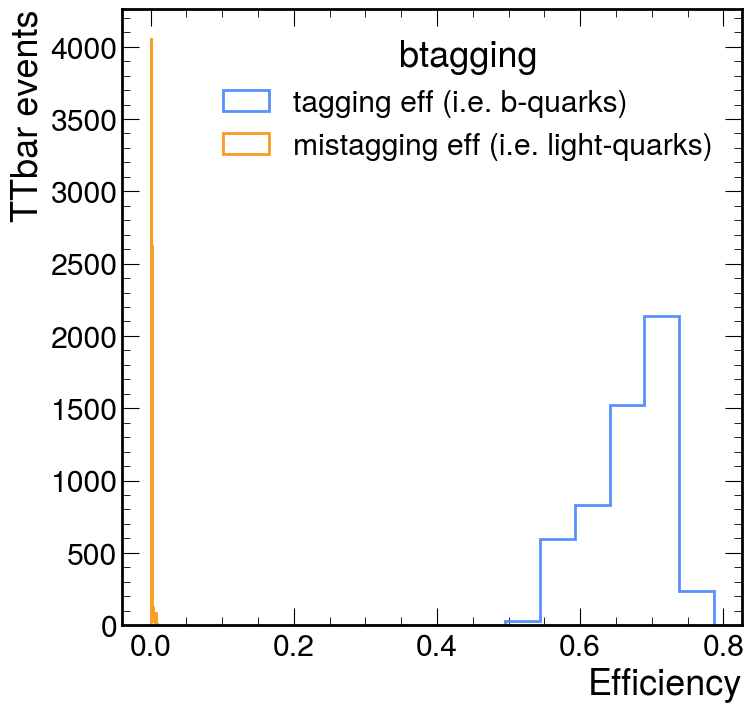

In [184]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(btga_dict["bcEff"], histtype="step", lw=2, label="tagging eff (i.e. b-quarks)");
ax.hist(btga_dict["lightEff"], histtype="step", lw=2, label="mistagging eff (i.e. light-quarks)");
ax.legend(title="btagging")
ax.set_ylabel("TTbar events")
ax.set_xlabel("Efficiency")

# Lookup

In [185]:
algo = "deepJet"
wp = "T"
ul_year = "2017_UL"

import importlib
from coffea import util as cutil

with importlib.resources.path("boostedhiggs.data", f"btageff_{algo}_{wp}_{ul_year}.coffea") as filename:
    efflookup = cutil.load(filename)

In [186]:
efflookup

3 dimensional histogram with axes:
	1: [ 40.  53.  66.  79.  92. 105. 118. 131. 144. 157. 170. 183. 196. 209.
 222. 235. 248. 261. 274. 287. 300.]
	2: [0.    0.625 1.25  1.875 2.5  ]
	3: [0. 1. 2. 3.]

In [187]:
lightJets = jets[jet_selector & (jets.hadronFlavour == 0)]
bcJets = jets[jet_selector & (jets.hadronFlavour > 0)]

lightEff = efflookup(lightJets.pt, abs(lightJets.eta), lightJets.hadronFlavour)
bcEff = efflookup(bcJets.pt, abs(bcJets.eta), bcJets.hadronFlavour)

Text(1, 0, 'number of jets')

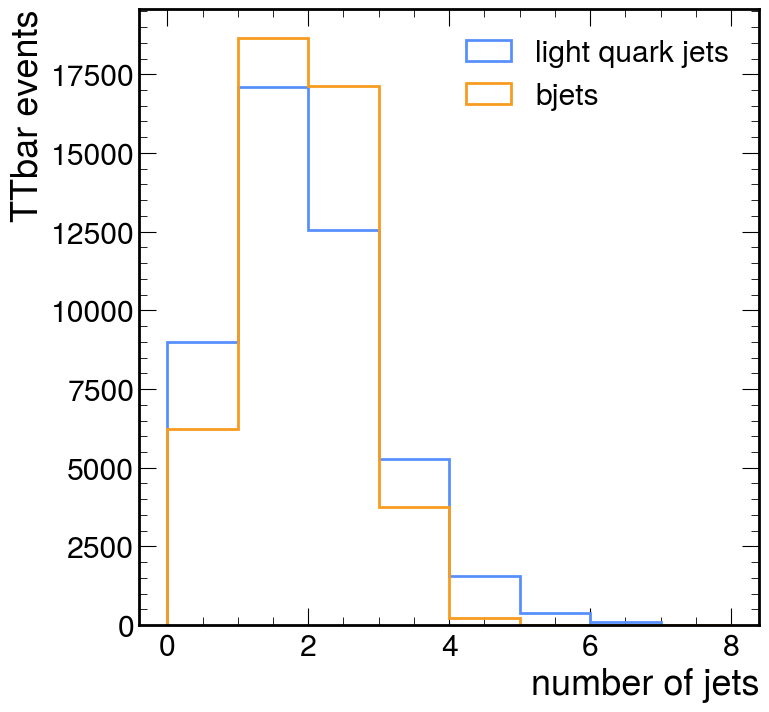

In [201]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(ak.num(lightJets), bins=np.linspace(0,8,9), histtype="step", lw=2, label="light quark jets");
ax.hist(ak.num(bcJets), bins=np.linspace(0,8,9), histtype="step", lw=2, label="bjets");
ax.legend()
ax.set_ylabel("TTbar events")
ax.set_xlabel("number of jets")

# How the lookup was built

https://btv-wiki.docs.cern.ch/PerformanceCalibration/fixedWPSFRecommendations/

In [1]:
import awkward as ak
import hist
import numpy as np
from coffea import util as cutil
from coffea.lookup_tools.dense_lookup import dense_lookup
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

import mplhep as hep

btagWPs = {
    "deepJet": {
        "2016preVFP_UL": {
            "L": 0.0508,
            "M": 0.2598,
            "T": 0.6502,
        },
        "2016postVFP_UL": {
            "L": 0.0480,
            "M": 0.2489,
            "T": 0.6377,
        },
        "2017_UL": {
            "L": 0.0532,
            "M": 0.3040,
            "T": 0.7476,
        },
        "2018_UL": {
            "L": 0.0490,
            "M": 0.2783,
            "T": 0.7100,
        },
    },
}

# # single TT files to derive efficiency
# tt_files = {
#     "2016preVFP_UL": "/store/user/lpcpfnano/cmantill/v2_3/2016APV/TTbar/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic/220808_173625/0000/nano_mc2016pre_3-146.root",
#     "2016postVFP_UL": "/store/user/lpcpfnano/cmantill/v2_3/2016/TTbar/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic/220808_181840/0000/nano_mc2016post_3-30.root",
#     "2017_UL": "/store/user/lpcpfnano/rkansal/v2_3/2017/TTbar/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic/220705_160227/0000/nano_mc2017_227.root",
#     "2018_UL": "/store/user/lpcpfnano/cmantill/v2_3/2018/TTbar/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic/220808_151244/0000/nano_mc2018_2-15.root",
# }

##### I just copied them under btag/
tt_files = {
    "2016preVFP_UL": "btag/TTbar_2016preVFP_UL.root",
    "2016postVFP_UL": "btag/TTbar_2016postVFP_UL.root",
    "2017_UL": "btag/TTbar_2017_UL.root",
    "2018_UL": "btag/TTbar_2018_UL.root",
}

year_label = {
    "2016preVFP_UL": "2016APV",
    "2016postVFP_UL": "2016",
    "2017_UL": "2017",
    "2018_UL": "2018",
}

taggerBranch = {"deepJet": "btagDeepFlavB"}

for year, fname in tt_files.items():
    events = NanoEventsFactory.from_root(
#         f"root://cmsxrootd-site.fnal.gov/{fname}",        
        fname,
        entry_stop=100_000,
        schemaclass=NanoAODSchema,
    ).events()

    # b-tagging only applied for jets with |eta| < 2.5
    phasespace_cuts = (events.Jet.pt > 30) & (abs(events.Jet.eta) < 2.5)
    jets = ak.flatten(events.Jet[phasespace_cuts])

    for tag in ["deepJet"]:
        for wp in ["T"]:
            efficiencyinfo = (
                hist.Hist.new.Reg(20, 40, 300, name="pt")
                .Reg(4, 0, 2.5, name="abseta")
                .IntCat([0, 4, 5], name="flavor")
                .Bool(name="passWP")
                .Double()
                .fill(
                    pt=jets.pt,
                    abseta=abs(jets.eta),
                    flavor=jets.hadronFlavour,
                    passWP=jets[taggerBranch[tag]] > btagWPs[tag][year][wp],
                )
            )
            eff = efficiencyinfo[{"passWP": True}] / efficiencyinfo[{"passWP": sum}]
            
            # make 2dplot of the eff
            flavors = list(eff.axes["flavor"])
            for flavor in range(len(list(eff.axes["flavor"]))):

                fig, ax = plt.subplots(figsize=(15, 15))

                h = eff[{"flavor": flavor}]
                hep.hist2dplot(h, ax=ax, flow=None)

                for i in range(h.axes[0].size):
                    for j in range(h.axes[1].size):
                        bin_value = h.values()[i, j]
                        bin_center_x = h.axes[0].centers[i]
                        bin_center_y = h.axes[1].centers[j]
                        ax.text(bin_center_x, bin_center_y, f'{bin_value:.2f}', 
                                color='white', ha='center', va='center', fontsize=10)
            
                ax.set_title(f'B-tagging efficiency map {year_label[year]} (flavor={flavors[flavor]})', pad=24)
                ax.set_xlabel(r"$p_T$")
                ax.set_ylabel(r"$\eta$")

                plt.tight_layout()    
                plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/btag/{tag}_{wp}_{year_label[year]}_{flavors[flavor]}.pdf")            

/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1813 branches) at 0x0001a98c06d0>, taking first instance
  warnings.warn(
/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1813 branches) at 0x0001a98c06d0>, taking first instance
  warnings.warn(
/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1813 branches) at 0x0001a98c06d0>, taking first instance
  warnings.warn(
/Users/fmokhtar/miniconda3/envs/fastjet-env/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Events' (1813 branc

NameError: name 'plt' is not defined

In [313]:
np.mean(eff[{"flavor": 2}].values())

0.6597583276023764

In [324]:
np.mean(eff[{"flavor": 1}].values())

0.03625828169660683